# Common Lifetime Questions

* How do desity models and solar flux affect lifetime predictions?
* What are the effects of Gaussian quadrature on lifetime?
* What are the effects of orbit epoch on lifetime for LEOs?
* How does the Lifetime Tool compare to HPOP?

## Summary of Findings
* Recommended Lifetime Tool Settings:
    * Turn 2nd Order Oblateness Off
    * Density models
        * Generally use: Jacchia 1970,Jacchia 1971,Jacchia-Roberts,MSIS 1986, MSISE 1990,NRLMSISE 2000s,DTM 2012
        * Generally avoid: 1976 Standard, Harris-Preister, CIRA 1971
    * The SpaceWeather-All-v1.2.txt and the SolFlx_CSSI.dat give similar results for most LEOs. But the SpaceWeather-All-v1.2.txt predicts a higher solar maximum. The SpaceWeather-All-v1.2.txt is also good for historical data. 
    * Use the SolFlx_CSSI.dat file for orbit predictions longer than 25 years. 
    * Set Gaussian Quadrature to 2. For eccentric orbits maybe bump this up to 4 or 8
    * Set Orbits Per Calculation to 1 for slightly increased accuracy, leave it at the defauly 10 for better computation speed.
* Comparing the Lifetime Tool to HPOP for a set of 500+ LEOs, resulted in a mean percent error of 6.6% and a median error of 4.2%. The error is typically lower when the LEOs decayed during solar maximums and the error typically increased when the LEOs decayed during solar minimums.


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 30)
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")
sns.set_palette('colorblind')
import os
import pickle
import time
import datetime
from functools import reduce
from comtypes.client import CreateObject
from comtypes.client import GetActiveObject
from comtypes.gen import STKObjects
from comtypes.gen import STKUtil
from comtypes.gen import AgSTKVgtLib
from IPython.display import Image
from LifeTimeLib import * 
%config Completer.use_jedi = False

# How do density models and solar flux affect lifetime predictions?

###  Look at the data set

In [2]:
# Load the trade study
tradeStudy = loadTradeStudy('LifeTimeGeneralTwo')
tradeStudy.properties()

{'fileName': 'LifeTimeGeneralTwo.csv',
 'numCores': 4,
 'runHPOP': False,
 'maxDur': 100,
 'decayAlt': 65,
 'epoch': 19253.16666667,
 'a': 6778,
 'e': 0,
 'i': 45,
 'AoP': 0,
 'RAAN': 0,
 'TA': 0,
 'Cd': 2.2,
 'Cr': 1.0,
 'DragArea': 13.65,
 'SunArea': 15.43,
 'Mass': 1000,
 'AtmDen': 'Jacchia 1971',
 'SolFlxFile': 'SolFlx_CSSI.dat',
 'SigLvl': 0,
 'OrbPerCal': 10,
 'GaussQuad': 2,
 'SecondOrderOblateness': 'Off',
 'howToVary': 'GridSearch',
 'numberOfRuns': 308000,
 'varyCols': ['Rp',
  'Ra',
  'i',
  'AoP',
  'RAAN',
  'Density Model',
  'Flux Sigma Level',
  'SolarFluxFile'],
 'varyValues': [array([6678, 6778, 6878, 6978, 7078]),
  array([6678, 6778, 6878, 6978, 7078]),
  array([  0,  30,  60,  90, 120, 150, 180]),
  array([  0,  90, 180, 270]),
  array([  0,  90, 180, 270]),
  array(['1976 Standard', 'Harris-Priester', 'Jacchia 1970', 'Jacchia 1971',
         'Jacchia-Roberts', 'CIRA 1972', 'DTM 2012', 'NRLMSISE 2000',
         'MSISE 1990', 'MSIS 1986', 'Jacchia70Lifetime'], dtype

In [3]:
# Load Data Frame
dfRes = readResults(tradeStudy)
dfRes

,Run ID,a,e,i,RAAN,AoP,TA,Rp,Ra,p,x,y,z,Vx,Vy,Vz,Cd,Cr,Drag Area,Sun Area,Mass,Cd*Drag Area/Mass,Cr*Sun Area/Mass,Orb Per Calc,Gaussian Quad,Flux Sigma Level,SolarFluxFile,Density Model,2nd Order Oblateness,LT Orbits,LT Years,LT Runtime
0,0.0,6678.0,0.000000,0.0,0.0,0.0,0.0,6678.0,6678.0,6678.000000,6678.0,0.0,0.0,0.0,7.725839,0.0,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,-2.0,SolFlx_CSSI.dat,1976 Standard,Off,245.0,0.040414,0.010098
1,1.0,6728.0,0.007432,0.0,0.0,0.0,0.0,6678.0,6778.0,6727.628419,6678.0,0.0,0.0,0.0,7.754494,0.0,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,-2.0,SolFlx_CSSI.dat,1976 Standard,Off,632.0,0.107350,0.016999
2,2.0,6778.0,0.014754,0.0,0.0,0.0,0.0,6678.0,6878.0,6776.524639,6678.0,0.0,0.0,0.0,7.782623,0.0,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,-2.0,SolFlx_CSSI.dat,1976 Standard,Off,1213.0,0.209270,0.010079
3,3.0,6828.0,0.021968,0.0,0.0,0.0,0.0,6678.0,6978.0,6824.704745,6678.0,0.0,0.0,0.0,7.810240,0.0,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,-2.0,SolFlx_CSSI.dat,1976 Standard,Off,1959.0,0.341711,0.020152
4,4.0,6878.0,0.029078,0.0,0.0,0.0,0.0,6678.0,7078.0,6872.184356,6678.0,0.0,0.0,0.0,7.837361,0.0,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,-2.0,SolFlx_CSSI.dat,1976 Standard,Off,2836.0,0.499247,0.020198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307995,307995.0,6878.0,0.029078,180.0,270.0,270.0,0.0,6678.0,7078.0,6872.184356,6678.0,0.0,-0.0,0.0,-7.837361,-0.0,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,Jacchia70Lifetime,Off,5605.0,0.986595,0.181499
307996,307996.0,6928.0,0.021651,180.0,270.0,270.0,0.0,6778.0,7078.0,6924.752309,6778.0,0.0,-0.0,0.0,-7.751209,-0.0,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,Jacchia70Lifetime,Off,22729.0,4.096450,0.683766
307997,307997.0,6978.0,0.014331,180.0,270.0,270.0,0.0,6878.0,7078.0,6976.566925,6878.0,0.0,-0.0,0.0,-7.667038,-0.0,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,Jacchia70Lifetime,Off,39858.0,7.249065,1.508158
307998,307998.0,7028.0,0.007114,180.0,270.0,270.0,0.0,6978.0,7078.0,7027.644280,6978.0,0.0,-0.0,0.0,-7.584777,-0.0,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,Jacchia70Lifetime,Off,99158.0,18.248193,2.982066


In [4]:
# Summary statistics
dfRes.describe()

,Run ID,a,e,i,RAAN,AoP,TA,Rp,Ra,p,x,y,z,Vx,Vy,Vz,Cd,Cr,Drag Area,Sun Area,Mass,Cd*Drag Area/Mass,Cr*Sun Area/Mass,Orb Per Calc,Gaussian Quad,Flux Sigma Level,LT Orbits,LT Years,LT Runtime
count,308000.000000,308000.000000,308000.000000,308000.000000,308000.000000,308000.000000,308000.0,308000.000000,308000.000000,308000.000000,308000.000000,308000.000000,3.080000e+05,3.080000e+05,3.080000e+05,3.080000e+05,3.080000e+05,308000.0,3.080000e+05,3.080000e+05,308000.0,3.080000e+05,3.080000e+05,308000.0,308000.0,308000.000000,308000.000000,308000.000000,308000.000000
mean,153999.500000,6878.000000,0.011633,90.000000,135.000000,135.000000,0.0,6798.000000,6958.000000,6876.545981,0.000000,0.000000,1.417394e-16,-1.586033e-19,-3.027881e-19,1.622007e-16,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,2.0,0.000000,60799.014955,9.460994,0.998035
std,88912.085793,100.000162,0.008724,60.000097,100.623222,100.623222,0.0,116.619227,116.619227,100.021830,4261.505833,4261.505833,3.147331e+03,4.828226e+00,4.828226e+00,3.565881e+00,4.177998e-12,0.0,6.470923e-11,2.956928e-11,0.0,9.062557e-14,6.307465e-15,0.0,0.0,1.000002,150055.475464,18.240860,2.342495
min,0.000000,6678.000000,0.000000,0.000000,0.000000,0.000000,0.0,6678.000000,6678.000000,6678.000000,-7078.000000,-7078.000000,-7.078000e+03,-7.837361e+00,-7.837361e+00,-7.837361e+00,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,2.0,-2.000000,195.000000,0.031749,0.007086
25%,76999.750000,6828.000000,0.007114,30.000000,67.500000,67.500000,0.0,6678.000000,6878.000000,6824.704745,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,2.0,0.000000,4542.000000,0.795226,0.114974
50%,153999.500000,6878.000000,0.007432,90.000000,135.000000,135.000000,0.0,6778.000000,6978.000000,6876.546089,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,2.0,0.000000,19801.500000,3.505933,0.280832
75%,230999.250000,6928.000000,0.014754,150.000000,202.500000,202.500000,0.0,6878.000000,7078.000000,6927.639145,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,2.0,0.000000,39144.000000,7.096718,0.763064
max,307999.000000,7078.000000,0.029078,180.000000,270.000000,270.000000,0.0,7078.000000,7078.000000,7078.000000,7078.000000,7078.000000,7.078000e+03,7.837361e+00,7.837361e+00,7.837361e+00,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,2.0,2.000000,999999.000000,100.000000,38.231680


In [5]:
# Look at correlations
colsToDrop = ['x','y','z','Vx','Vy','Vz','TA','p','LT Orbits','SolarFluxFile','Density Model','2nd Order Oblateness']
corrMat = dfRes.drop(colsToDrop,axis=1).corr()['LT Years'].sort_values(ascending=False)
pd.DataFrame(corrMat[abs(corrMat) > 0.001]*100)

,LT Years
LT Years,100.000000
LT Runtime,79.040258
Rp,75.492637
a,67.983962
Ra,41.098897
AoP,-0.368994
i,-3.999924
Flux Sigma Level,-6.411208
e,-33.849879


In [6]:
# Sort by longest lifetime
dfRes.iloc[dfRes['LT Years'].sort_values(ascending=False).index]

,Run ID,a,e,i,RAAN,AoP,TA,Rp,Ra,p,x,y,z,Vx,Vy,Vz,Cd,Cr,Drag Area,Sun Area,Mass,Cd*Drag Area/Mass,Cr*Sun Area/Mass,Orb Per Calc,Gaussian Quad,Flux Sigma Level,SolarFluxFile,Density Model,2nd Order Oblateness,LT Orbits,LT Years,LT Runtime
307999,307999.0,7078.0,0.0,180.0,270.0,270.0,0.0,7078.0,7078.0,7078.0,7078.000000,0.0,-0.000000,0.000000,-7.504359,-0.00000,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,Jacchia70Lifetime,Off,999999.0,100.000000,17.003128
195699,195699.0,7078.0,0.0,30.0,270.0,180.0,0.0,7078.0,7078.0,7078.0,0.000000,7078.0,0.000000,-6.498966,0.000000,-3.75218,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,Jacchia 1971,Off,999999.0,100.000000,3.645657
195499,195499.0,7078.0,0.0,0.0,270.0,90.0,0.0,7078.0,7078.0,7078.0,7078.000000,-0.0,0.000000,0.000000,7.504359,0.00000,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,Jacchia 1971,Off,999999.0,100.000000,3.520166
195524,195524.0,7078.0,0.0,30.0,270.0,90.0,0.0,7078.0,7078.0,7078.0,6129.727808,-0.0,3539.000000,0.000000,7.504359,0.00000,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,Jacchia 1971,Off,999999.0,100.000000,3.746439
195549,195549.0,7078.0,0.0,60.0,270.0,90.0,0.0,7078.0,7078.0,7078.0,3539.000000,-0.0,6129.727808,0.000000,7.504359,0.00000,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,Jacchia 1971,Off,999999.0,100.000000,4.393808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186525,186525.0,6678.0,0.0,180.0,180.0,90.0,0.0,6678.0,6678.0,6678.0,0.000000,6678.0,0.000000,7.725839,-0.000000,0.00000,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,1976 Standard,Off,195.0,0.031749,0.062483
33400,33400.0,6678.0,0.0,180.0,270.0,180.0,0.0,6678.0,6678.0,6678.0,0.000000,6678.0,0.000000,7.725839,-0.000000,-0.00000,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,-1.0,SolFlx_CSSI.dat,1976 Standard,Off,195.0,0.031749,0.020164
187400,187400.0,6678.0,0.0,180.0,270.0,180.0,0.0,6678.0,6678.0,6678.0,0.000000,6678.0,0.000000,7.725839,-0.000000,-0.00000,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,1976 Standard,Off,195.0,0.031749,0.070562
216275,216275.0,6678.0,0.0,180.0,0.0,270.0,0.0,6678.0,6678.0,6678.0,-0.000000,6678.0,-0.000000,7.725839,0.000000,-0.00000,2.2,1.0,13.65,15.43,1000.0,0.03003,0.01543,10.0,2.0,0.0,SpaceWeather-v1.2.txt,1976 Standard,Off,195.0,0.031749,0.060402


### Compare Density Models to Lifetime Predictions

In [7]:
# Group by density model
dfRes.groupby('Density Model').describe()[['LT Years','LT Runtime']]

LT Years                                            \
                     count       mean        std       min       25%   
Density Model                                                          
1976 Standard      28000.0   5.802076  10.764018  0.031749  0.345971   
CIRA 1972          28000.0   9.343094  18.211457  0.051983  0.834005   
DTM 2012           28000.0   9.890248  18.615427  0.052461  1.090411   
Harris-Priester    28000.0  10.371307  19.017756  0.058055  0.902790   
Jacchia 1970       28000.0  10.222780  19.538329  0.049381  0.824688   
Jacchia 1971       28000.0   9.305276  18.205850  0.047577  0.763132   
Jacchia-Roberts    28000.0   9.240995  18.079402  0.049369  0.776610   
Jacchia70Lifetime  28000.0   9.896246  18.931611  0.048817  0.825499   
MSIS 1986          28000.0  10.035585  19.072144  0.050407  0.913255   
MSISE 1990         28000.0   9.922908  18.937104  0.050060  0.897382   
NRLMSISE 2000      28000.0  10.040425  19.168718  0.050617  0.901862   

                                                  LT Runtime            \
                        50%       75%         max      count      mean   
Density Model                                                            
1976 Standard      1.286151  5.767463   56.905524    28000.0  0.163688   
CIRA 1972          3.581212  6.780978  100.000000    28000.0  2.594429   
DTM 2012           3.878020  7.005695  100.000000    28000.0  0.832247   
Harris-Priester    3.574989  9.092654  100.000000    28000.0  0.292722   
Jacchia 1970       3.618149  7.412164  100.000000    28000.0  0.889256   
Jacchia 1971       3.569021  6.770053  100.000000    28000.0  0.416305   
Jacchia-Roberts    3.567601  6.745603  100.000000    28000.0  0.499769   
Jacchia70Lifetime  3.595994  7.243183  100.000000    28000.0  1.706464   
MSIS 1986          3.675147  7.255138  100.000000    28000.0  1.095100   
MSISE 1990         3.661036  7.111097  100.000000    28000.0  1.218879   
NRLMSISE 2000      3.645260  7.087814  100.000000    28000.0  1.269520   

                                                                                
                        std       min       25%       50%       75%        max  
Density Model                                                                   
1976 Standard      0.216776  0.007098  0.050365  0.089785  0.171026   2.372623  
CIRA 1972          4.954645  0.022162  0.291652  0.995952  1.960346  38.231680  
DTM 2012           1.470567  0.010052  0.141089  0.352434  0.655007  14.981592  
Harris-Priester    0.445065  0.008055  0.072784  0.140799  0.281744   4.506576  
Jacchia 1970       1.668240  0.009999  0.120790  0.311942  0.674268  14.221167  
Jacchia 1971       0.713530  0.007086  0.089205  0.183150  0.341813   7.727448  
Jacchia-Roberts    0.876115  0.009077  0.095771  0.216701  0.402497   9.506904  
Jacchia70Lifetime  3.226795  0.010047  0.163505  0.607821  1.330794  25.605024  
MSIS 1986          1.948438  0.012089  0.161007  0.443265  0.862776  16.174265  
MSISE 1990         2.202120  0.018135  0.171623  0.493190  0.952950  19.461452  
NRLMSISE 2000      2.299178  0.019086  0.179053  0.501580  0.986230  18.939506

#### So which density model should you use?

Models you might want to avoid:

* 1976 Standard gives answers much shorter lifetime predictions than other models. 
* Harris-Preister has the same issue, but with a tendancy to predict longer lifetimes. So these should likely be ruled out.
* CIRA 1971 and Jacchia70Lifetime take much longer to run than other models with seemingly no additional accuracy benefits.

The remaining density models tend to give relatively similar lifetime predictions:

* Jacchia 1971 and Jacchia-Roberts appear to be the fastest remaining density models with a tendancy to predict slightly shorter lifetimes.
* Jacchia 1970 also has a moderately fast computation time.
* MSIS 1986, MSISE 1990, and NRLMSISE 2000 all gave similar lifetime predictions with moderate runtimes.
* DTM 2012 tends to predicts slightly longer lifetimes, with moderately fast computation times.

These density models tend to give fairly similar answers, with no clear winner. But in terms of computation time Jacchia 1971 and Jacchia-Roberts tend to be the fastest.


### Compare Solar Flux Files and Sigmas to Lifetime Predictions

In [8]:
# Group by flux sigma level
dfRes[dfRes['SolarFluxFile'] =='SolFlx_CSSI.dat'].groupby('Flux Sigma Level').describe()['LT Years']

,count,mean,std,min,25%,50%,75%,max
Flux Sigma Level,,,,,,,,
-2.0,30800.0,11.526227,20.656261,0.031749,0.766949,3.463624,10.744568,100.000000
-1.0,30800.0,10.217658,18.344278,0.031749,0.755703,3.300101,8.795322,100.000000
0.0,30800.0,8.895619,15.497216,0.031749,0.744855,3.167595,7.538378,99.683472
1.0,30800.0,7.805515,13.184901,0.031749,0.735121,3.060987,6.748017,87.525056
2.0,30800.0,6.885011,11.288259,0.031749,0.725547,2.967849,6.204218,66.933774


As expected, as the flux sigma level increases the orbit lifetimes tends to go down, because the atmosphere would increase in size leading to more drag.

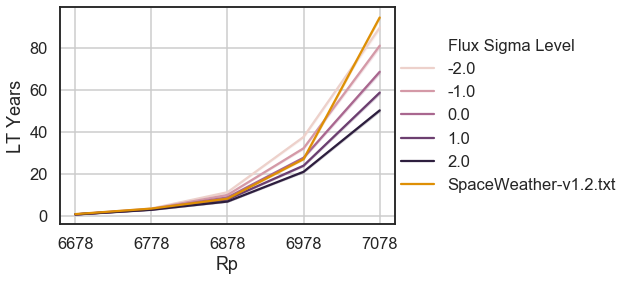

In [9]:
# Plot mean lifetime vs radius of periapsis for different solar flux file values
dfSubset = dfRes[dfRes['SolarFluxFile'] =='SolFlx_CSSI.dat']
sns.lineplot('Rp','LT Years',legend = 'full',hue='Flux Sigma Level',data=dfSubset)
dfSubset = dfRes[dfRes['SolarFluxFile'] =='SpaceWeather-v1.2.txt']
sns.lineplot('Rp','LT Years',legend='full',data=dfSubset,label='SpaceWeather-v1.2.txt')
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.5),borderaxespad=0, frameon=False);
plt.grid(True)
plt.xticks(np.arange(6678,7178,100));

Below are the F10.7 values plotted over the next 25 years showing the nominal, +- 2$\sigma$ values and the spaceweather predicts. The spaceweather file runs out after 25 years and then the last values in the file are used, therefore this file should not be used for lifetime predictions longer than 25 years. This explains the difference in the lifetime predictions for higher orbital altitudes which take longer than 25 years to decay, as shown in the plot above.

![title](SolarFluxFilesPredict.png)

Let's compare the SolFlx_CSSI with nominal flux to the SpaceWeather file for orbits with radius of periapsis <= 6878 km (because the lifetime for these orbits are < 25 years).

In [10]:
dfRes[(dfRes['Flux Sigma Level'] ==0) & (dfRes['Rp']<=6878)].groupby('SolarFluxFile').describe()['LT Years']

,count,mean,std,min,25%,50%,75%,max
SolarFluxFile,,,,,,,,
SolFlx_CSSI.dat,25872.0,3.371052,3.886500,0.031749,0.609367,1.941834,4.573743,19.907951
SpaceWeather-v1.2.txt,129360.0,3.375265,3.567432,0.031749,0.680048,2.434701,4.574105,17.185988


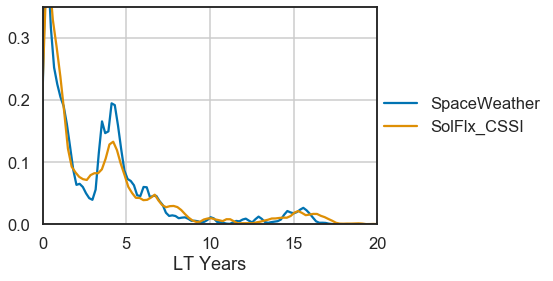

In [11]:
# Plot the distribution of lifetimes
dfSubset = dfRes.loc[(dfRes['SolarFluxFile'] =='SpaceWeather-v1.2.txt') & (dfRes['Rp']<6978)]
sns.distplot(dfSubset['LT Years'],hist=False,kde_kws={'kernel':'epa'},bins=50,label='SpaceWeather');
dfSubset = dfRes[(dfRes['SolarFluxFile'] =='SolFlx_CSSI.dat') & (dfRes['Flux Sigma Level'] ==0) & (dfRes['Rp']<6978)]
sns.distplot(dfSubset['LT Years'],hist = False,kde_kws={'kernel':'epa'},bins=50,label='SolFlx_CSSI');
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.5),borderaxespad=0, frameon=False);
plt.grid(True)
plt.xlim([0,20]);
plt.ylim([0,0.35]);

The mean lifetime predictions across many satellites are similar, but there are some differences in the lifetime distributions, especially around the solar maximums. The next solar maximum is expected to start around 2023, which is about 3.5 years from the dataset's epoch. Since the spaceweather file predicts a higher solar maximum, an thus a bit more drag, a few more satellites come down during this time period when compared to the CSSI predictions.

## What are the effects of Gaussian quadrature on lifetime?

###  Look at the data set

In [12]:
# Load the trade study
tradeStudy = loadTradeStudy('LifeTimeResultsGaussQuad')
tradeStudy.properties()

{'fileName': 'LifeTimeResultsGaussQuad.csv',
 'numCores': 4,
 'runHPOP': False,
 'maxDur': 100,
 'decayAlt': 65,
 'epoch': 19253.16666667,
 'a': 6778,
 'e': 0,
 'i': 45,
 'AoP': 0,
 'RAAN': 0,
 'TA': 0,
 'Cd': 2.2,
 'Cr': 1.0,
 'DragArea': 13.65,
 'SunArea': 15.43,
 'Mass': 1000,
 'AtmDen': 'Jacchia 1971',
 'SolFlxFile': 'SolFlx_CSSI.dat',
 'SigLvl': 0,
 'OrbPerCal': 10,
 'GaussQuad': 2,
 'SecondOrderOblateness': 'Off',
 'howToVary': 'GridSearch',
 'numberOfRuns': 14240,
 'varyCols': ['Rp', 'Ra', 'Gaussian Quad'],
 'varyValues': [array([6678, 6778, 6878, 6978, 7078, 7178, 7278, 7378]),
  array([ 6678,  6878,  7078,  7278,  7478,  7678,  7878,  8078,  8278,
          8478,  8678,  8878,  9078,  9278,  9478,  9678,  9878, 10078,
         10278, 10478, 10678, 10878, 11078, 11278, 11478, 11678, 11878,
         12078, 12278, 12478, 12678, 12878, 13078, 13278, 13478, 13678,
         13878, 14078, 14278, 14478, 14678, 14878, 15078, 15278, 15478,
         15678, 15878, 16078, 16278, 16478, 166

In [13]:
# Load Data Frame
dfRes = readResults(tradeStudy)
dfRes.describe()

,a,e,i,RAAN,AoP,TA,Rp,Ra,p,x,y,z,Vx,Vy,Vz,Cd,Cr,Drag Area,Sun Area,Mass,Cd*Drag Area/Mass,Cr*Sun Area/Mass,Orb Per Calc,Gaussian Quad,Flux Sigma Level,LT Orbits,LT Years,LT Runtime,HPOP Years,HPOP Runtime
count,14240.000000,14240.000000,14240.0,14240.0,14240.0,14240.0,14240.000000,14240.000000,14240.000000,14240.000000,14240.0,14240.0,14240.0,14240.000000,14240.0,1.424000e+04,14240.0,1.424000e+04,1.424000e+04,14240.0,1.424000e+04,1.424000e+04,14240.0,14240.000000,14240.0,14240.000000,14240.000000,14240.000000,0.0,0.0
mean,15703.000000,0.493052,0.0,0.0,0.0,0.0,7024.488764,24381.511236,10486.956849,7024.488764,0.0,0.0,0.0,9.187735,0.0,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,20.500000,0.0,839927.088553,88.250308,10.248776,NaN,NaN
std,5139.793786,0.192650,0.0,0.0,0.0,0.0,229.416252,10271.096130,1386.808563,229.416252,0.0,0.0,0.0,0.637301,0.0,5.036148e-13,0.0,3.511981e-12,4.821202e-12,0.0,6.871610e-15,2.555337e-15,0.0,23.880746,0.0,348502.893860,27.223621,18.355574,NaN,NaN
min,6678.000000,0.000000,0.0,0.0,0.0,0.0,6678.000000,6678.000000,6678.000000,6678.000000,0.0,0.0,0.0,7.374904,0.0,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,1.000000,0.0,378.000000,0.063187,0.015625,NaN,NaN
25%,11265.500000,0.375820,0.0,0.0,0.0,0.0,6778.000000,15478.000000,9640.568281,6778.000000,0.0,0.0,0.0,8.818591,0.0,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,3.000000,0.0,999999.000000,100.000000,1.805241,NaN,NaN
50%,15703.000000,0.552448,0.0,0.0,0.0,0.0,6978.000000,24378.000000,10872.858127,6978.000000,0.0,0.0,0.0,9.361958,0.0,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,7.500000,0.0,999999.000000,100.000000,4.113840,NaN,NaN
75%,20140.500000,0.651192,0.0,0.0,0.0,0.0,7178.000000,33278.000000,11549.683348,7178.000000,0.0,0.0,0.0,9.662329,0.0,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,35.000000,0.0,999999.000000,100.000000,10.698422,NaN,NaN
max,24728.000000,0.726064,0.0,0.0,0.0,0.0,7378.000000,42078.000000,12554.653995,7378.000000,0.0,0.0,0.0,10.150190,0.0,2.200000e+00,1.0,1.365000e+01,1.543000e+01,1000.0,3.003000e-02,1.543000e-02,10.0,75.000000,0.0,999999.000000,100.000000,237.880786,NaN,NaN


In [14]:
# Group by Gaussian Quad
dfRes.groupby('Gaussian Quad').describe()[['LT Years','LT Runtime']]

LT Years                                                       \
                 count       mean        std       min    25%    50%    75%   
Gaussian Quad                                                                 
1.0             1424.0  85.585334  30.881378  0.064201  100.0  100.0  100.0   
2.0             1424.0  88.571547  26.761921  0.063859  100.0  100.0  100.0   
3.0             1424.0  88.330531  27.131990  0.063860  100.0  100.0  100.0   
4.0             1424.0  88.563549  26.744869  0.063187  100.0  100.0  100.0   
5.0             1424.0  88.566900  26.739977  0.063864  100.0  100.0  100.0   
10.0            1424.0  88.593132  26.707773  0.063868  100.0  100.0  100.0   
20.0            1424.0  88.578845  26.723405  0.063868  100.0  100.0  100.0   
35.0            1424.0  88.577814  26.725942  0.063868  100.0  100.0  100.0   
50.0            1424.0  88.561805  26.744845  0.063696  100.0  100.0  100.0   
75.0            1424.0  88.573626  26.733229  0.063864  100.0  100.0  100.0   

                     LT Runtime                                             \
                 max      count       mean        std       min        25%   
Gaussian Quad                                                                
1.0            100.0     1424.0   1.232658   0.754199  0.020178   0.676055   
2.0            100.0     1424.0   2.768594   2.008086  0.015625   1.611458   
3.0            100.0     1424.0   2.797144   2.929963  0.015628   0.985677   
4.0            100.0     1424.0   3.222421   3.110397  0.015627   1.485915   
5.0            100.0     1424.0   3.649028   2.900933  0.028199   1.900848   
10.0           100.0     1424.0   5.538445   5.865355  0.038226   2.389268   
20.0           100.0     1424.0   9.894951   9.831170  0.062339   4.195715   
35.0           100.0     1424.0  16.623898  17.885801  0.108803   6.736492   
50.0           100.0     1424.0  23.129134  26.501587  0.137019   8.496834   
75.0           100.0     1424.0  33.631484  33.537801  0.169076  13.576868   

                                                 
                     50%        75%         max  
Gaussian Quad                                    
1.0             0.989015   1.683245    4.819764  
2.0             1.956154   3.528247   12.778517  
3.0             1.352996   3.424124   18.303892  
4.0             2.097309   3.848780   21.319936  
5.0             2.637458   4.403501   20.295271  
10.0            3.282328   5.771242   35.851994  
20.0            6.338637  11.699935   57.164548  
35.0           10.416799  18.589202  109.301926  
50.0           12.802097  26.376582  164.872130  
75.0           20.179277  41.619779  237.880786

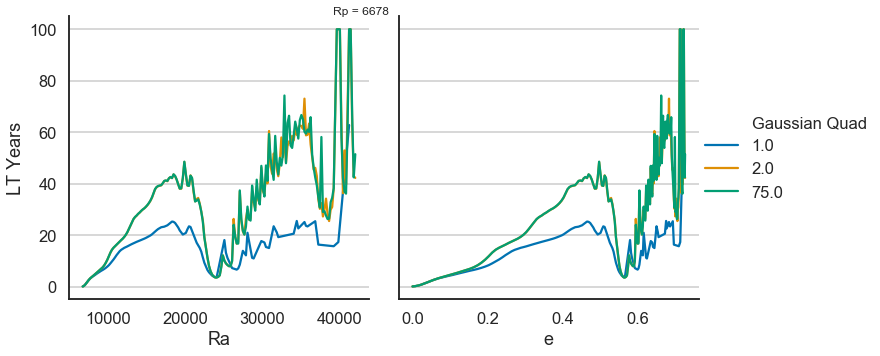

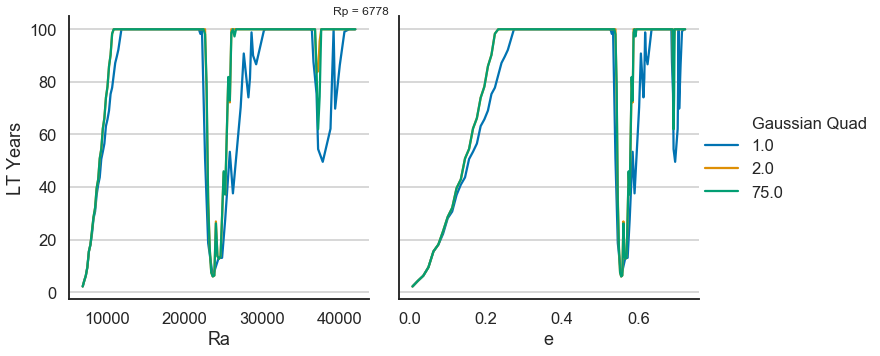

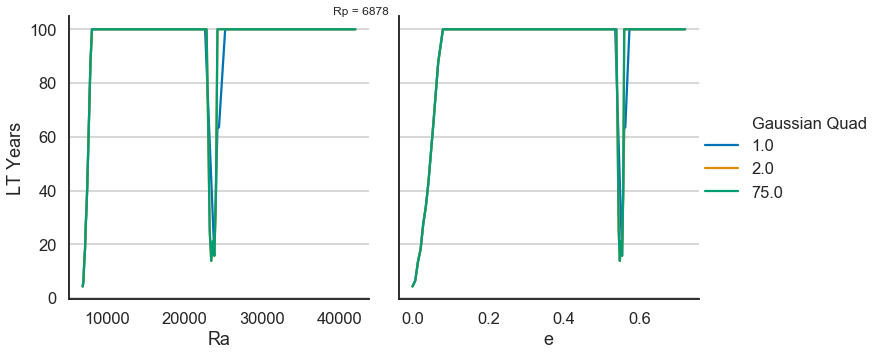

In [15]:
for Rpval in [6678,6778,6878]:
    dfSubset = dfRes[np.logical_and(dfRes['Rp']==Rpval ,dfRes['Gaussian Quad'].isin([1,2,75]))]
    g = sns.PairGrid(dfSubset, y_vars=['LT Years'], x_vars=['Ra','e'], height=5)
    g.map(sns.lineplot,hue='Gaussian Quad',palette=sns.color_palette('colorblind')[0:3],legend='full',data=dfSubset)
    plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.5),
                borderaxespad=0, frameon=False);
    plt.subplots_adjust(wspace = 0.1)
    ax1 = g.axes[0,0]
    ax1.grid(True,axis='y')
    ax2 = g.axes[0,1]
    ax2.grid(True,axis='y')
    g.fig.suptitle('Rp = '+str(Rpval));

(5, 103)

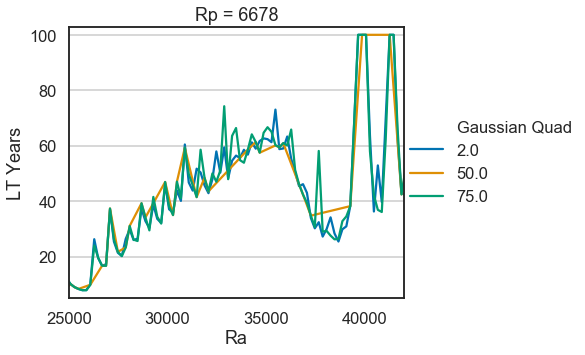

In [16]:
plt.figure(figsize=(6,5))
dfSubset = dfRes[np.logical_and(dfRes['Rp']==6678 ,dfRes['Gaussian Quad'].isin([2,50,75]))]
sns.lineplot(x='Ra',y='LT Years',hue='Gaussian Quad',palette=sns.color_palette('colorblind')[0:3],legend='full',data=dfSubset);
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.5),borderaxespad=0, frameon=False);
plt.title('Rp = 6678');
plt.grid(True,axis='y')
plt.xlim([25000,42000])
plt.ylim([5,103])

Increasing the number of Gaussian Quadratures has a near linear relationship with the runtime, but it doesn't seem to give much increased accuracy after a value of 2. Thus, for orbits with eccentricity > ~0.1 this analysis suggests setting the Gaussian Quadratures to a value of 2 (4 or 8 may also be a good choice), much beyond that appears to increase computation time with minimal effects on the orbit lifetime predictions. In fact increasing Gaussian Quadratures sometimes seems to make the predictions worse, due to moving the locations of where the orbit is sampled for drag. There also appears to be a pattern where multiples of 2 times tend to lead to the similar lifetime preditions, i.e.: 2,4,8 and 5,10,20, likely due to the sampling algorithm.

## What are the effects of orbit epoch on lifetime for LEOs?

### Look at the data set

In [17]:
# Load trade study
tradeStudy = loadTradeStudy('LifeTimeEpochs')
tradeStudy.properties()

{'fileName': 'LifeTimeEpochs.csv',
 'numCores': 4,
 'runHPOP': False,
 'maxDur': 100,
 'decayAlt': 65,
 'epoch': 19253.16666667,
 'a': 6778,
 'e': 0,
 'i': 45,
 'AoP': 0,
 'RAAN': 0,
 'TA': 0,
 'Cd': 2.2,
 'Cr': 1.0,
 'DragArea': 13.65,
 'SunArea': 15.43,
 'Mass': 1000,
 'AtmDen': 'Jacchia 1971',
 'SolFlxFile': 'SolFlx_CSSI.dat',
 'SigLvl': 0,
 'OrbPerCal': 10,
 'GaussQuad': 2,
 'SecondOrderOblateness': 'Off',
 'howToVary': 'GridSearch',
 'numberOfRuns': 9600,
 'varyCols': ['epoch', 'Rp', 'e', 'i', 'Aop'],
 'varyValues': [array([18001, 19001, 20001, 21001, 22001, 23001, 24001, 25001, 26001,
         27001, 28001, 29001, 30001, 31001, 32001, 33001, 34001, 35001,
         36001, 37001, 38001, 39001, 40001, 41001, 42001]),
  array([6678, 6778, 6878, 6978]),
  array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005]),
  array([ 0, 30, 60, 90]),
  array([  0,  90, 180, 270])],
 'setSunAreaEqualToDragArea': True}

In [18]:
# Load Data Frame
dfRes = readResults(tradeStudy)
dfRes.describe()

,Run ID,epoch,a,e,i,RAAN,AoP,TA,Rp,Ra,p,x,y,z,Vx,Vy,Vz,Cd,Cr,Drag Area,Sun Area,Mass,Cd*Drag Area/Mass,Cr*Sun Area/Mass,Orb Per Calc,Gaussian Quad,Flux Sigma Level,Aop,LT Orbits,LT Years,LT Runtime
count,9600.000000,9600.000000,9600.000000,9600.000000,9600.000000,9600.0,9600.0,9600.0,9600.000000,9600.000000,9600.000000,9600.000000,9600.0,9600.0,9600.0,9600.000000,9600.000000,9.600000e+03,9600.0,9.600000e+03,9.600000e+03,9600.0,9.600000e+03,9.600000e+03,9600.0,9600.0,9600.0,9600.0000,9600.000000,9600.000000,9600.000000
mean,4799.500000,30001.000000,6845.132847,0.002500,45.000000,0.0,0.0,0.0,6828.000000,6862.265694,6845.070000,6828.000000,0.0,0.0,0.0,4.525507,4.525507,2.200000e+00,1.0,1.365000e+01,1.365000e+01,1000.0,3.003000e-02,1.365000e-02,10.0,2.0,0.0,135.0000,39420.822917,7.147999,0.391231
std,2771.425626,7211.478159,112.701013,0.001708,33.542767,0.0,0.0,0.0,111.809222,114.789780,112.693909,111.809222,0.0,0.0,0.0,2.964825,2.964825,3.952600e-13,0.0,2.396430e-12,2.396430e-12,0.0,4.742981e-15,1.070380e-15,0.0,0.0,0.0,100.6283,52085.684215,9.507704,0.484434
min,0.000000,18001.000000,6678.000000,0.000000,0.000000,0.0,0.0,0.0,6678.000000,6678.000000,6678.000000,6678.000000,0.0,0.0,0.0,0.000000,0.000000,2.200000e+00,1.0,1.365000e+01,1.365000e+01,1000.0,3.003000e-02,1.365000e-02,10.0,2.0,0.0,0.0000,206.000000,0.033751,0.020171
25%,2399.750000,24001.000000,6761.389447,0.001000,22.500000,0.0,0.0,0.0,6753.000000,6769.778894,6761.347500,6753.000000,0.0,0.0,0.0,2.834227,2.834227,2.200000e+00,1.0,1.365000e+01,1.365000e+01,1000.0,3.003000e-02,1.365000e-02,10.0,2.0,0.0,67.5000,1447.750000,0.249948,0.050475
50%,4799.500000,30001.000000,6845.030151,0.002500,45.000000,0.0,0.0,0.0,6828.000000,6862.060302,6844.945000,6828.000000,0.0,0.0,0.0,5.208966,5.208966,2.200000e+00,1.0,1.365000e+01,1.365000e+01,1000.0,3.003000e-02,1.365000e-02,10.0,2.0,0.0,135.0000,10954.000000,1.932151,0.136026
75%,7199.250000,36001.000000,6928.922111,0.004000,67.500000,0.0,0.0,0.0,6903.000000,6954.844221,6928.792500,6903.000000,0.0,0.0,0.0,6.920094,6.920094,2.200000e+00,1.0,1.365000e+01,1.365000e+01,1000.0,3.003000e-02,1.365000e-02,10.0,2.0,0.0,202.5000,56513.250000,10.171694,0.598770
max,9599.000000,42001.000000,7013.065327,0.005000,90.000000,0.0,0.0,0.0,6978.000000,7048.130653,7012.890000,6978.000000,0.0,0.0,0.0,7.745130,7.745130,2.200000e+00,1.0,1.365000e+01,1.365000e+01,1000.0,3.003000e-02,1.365000e-02,10.0,2.0,0.0,270.0000,186476.000000,34.077603,5.139629


### Compare orbit epochs and eccentricity to lifetime

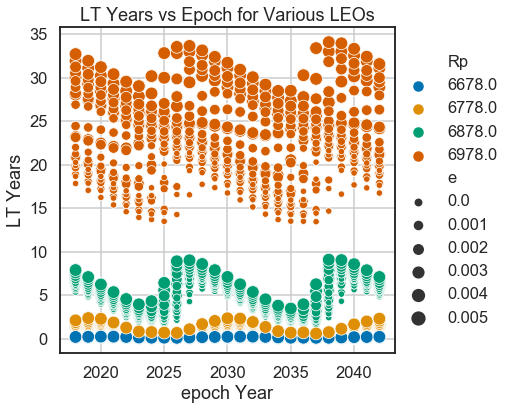

In [19]:
# Look at Epoch vs Lifetime for various LEOs
years = dfRes['epoch'].astype(str).str[0:2].astype(float)
fractionOfYears = (dfRes['epoch'].astype(str).str[2:].astype(float)-1)/365
dfRes['epoch Year'] = 2000+(years+fractionOfYears)
plt.figure(figsize=(6, 6))
sns.scatterplot(x='epoch Year',y='LT Years',hue='Rp',size='e',legend='full',palette=sns.color_palette('colorblind')[0:4],data=dfRes)
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.5),
            borderaxespad=0, frameon=False);
plt.xticks(np.arange(2020,2045,5))
plt.title('LT Years vs Epoch for Various LEOs');
plt.grid(True)

The orbit lifetimes follow the 11 year predicted solar cycle as expected. Also as expected, the orbits which are launched at the tail end of a solar maximum tend to have the longest orbit lifetimes and the shortest when launched right before a solar maximum. For LEOs with a radius of periapsis of 6978 km, the predicted lifetimes vary by 4-5 yrs between the solar maximum and solar minimum. LEOs with a radius of periapsis of 6878 km saw a 3-5 year of variation, for LEOs at 6778 km these variations are reduced to 1-2 years. Also as expected, as the radius of apoapsis is increased (controlled by eccentricity) the orbit lifetimes increase, especially at higher altitudes. A 6979 x 7048 km orbit may have a lifetime about twice as long as a 6969 x 6979 km orbit. 

## How does the Lifetime Tool compare to HPOP?

### Look at the data set

This dataset was generated by running 500+ LEOs with HPOP. For each orbit a grid search was performed using 3 values for orbits per calculcation, 3 values for Gaussian Quadrature and both the options for the 2nd Order Oblateness term.

In [20]:
# Load the trade study
tradeStudy = loadTradeStudy('LTVariationsVsHPOPLEO')
print(tradeStudy.properties()['varyCols'])
print(tradeStudy.properties()['varyValues'])

['Orb Per Calc', 'Gaussian Quad', '2nd Order Oblateness']
[array([ 1,  5, 10]), array([1, 2, 8]), array(['On', 'Off'], dtype='<U3')]


In [21]:
# Load Data Frame
tradeStudy = loadTradeStudy('LTVariationsVsHPOPLEO') # 376 LEOs between 6678 and 7078
dfRes1 = readResults(tradeStudy)
# Append more runs
tradeStudy = loadTradeStudy('LTVariationsVsHPOPLEOExtra') # 157 LEOs between 6878 and 7078
dfRes = readResults(tradeStudy)
dfRes = dfRes.append(dfRes1)

# Select which subset of data to look at
# dfRes = dfRes.loc[dfRes['LT Years']!=tradeStudy.maxDur] # Remove orbits which did not decay
# dfRes = dfRes.loc[dfRes['LT Years']>1] # Remove really short orbit lifetimes

# Add in useful additional columns
dfRes['Runtime Ratio'] = dfRes['HPOP Runtime']/dfRes['LT Runtime']
dfRes['Years Signed Error'] = dfRes['LT Years']-dfRes['HPOP Years']
dfRes['Years Abs Error'] = abs(dfRes['LT Years']-dfRes['HPOP Years'])
dfRes['Years % Error'] = abs(dfRes['LT Years']-dfRes['HPOP Years'])/dfRes['HPOP Years']*100
dfPlotting  = dfRes[(dfRes['Gaussian Quad'] == 2) & (dfRes['Orb Per Calc'] == 1)] # Reduces overlapping points when plotting and the recommended lifetime settings

# Summary statistics
dfRes.describe()

,Run ID,epoch,a,e,i,RAAN,AoP,TA,Rp,Ra,p,x,y,z,Vx,Vy,Vz,Cd,Cr,Drag Area,Sun Area,Mass,Cd*Drag Area/Mass,Cr*Sun Area/Mass,Orb Per Calc,Gaussian Quad,Flux Sigma Level,LT Orbits,LT Years,LT Runtime,HPOP Years,HPOP Runtime,Run ID Old,Runtime Ratio,Years Signed Error,Years Abs Error,Years % Error
count,9594.000000,9.594000e+03,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.0,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000,9594.000000
mean,2802.924015,1.925317e+04,6907.637423,0.008581,61.083490,181.508822,178.331747,179.606052,6848.477496,6966.797350,6906.813000,152.028834,-39.230026,-162.692720,-0.001055,-0.077582,-0.119667,1.996737,1.001495,93.774442,93.774442,1193.278625,0.172069,0.088399,5.333333,3.666667,0.0,22563.303002,4.095794,3.356856,4.211311,470.102883,208.864916,380.449392,-0.115517,0.386267,7.838669
std,1922.613585,2.608567e-09,81.676080,0.006790,34.923344,104.519126,102.426070,101.381330,101.729209,85.719364,81.901502,3981.299478,4119.498947,3855.086677,4.594946,4.400015,4.150570,0.291370,0.289644,55.859910,55.859910,485.016991,0.109951,0.065433,3.681979,3.091367,0.0,35786.966552,6.539593,11.445014,6.956683,2628.031892,144.007338,2453.008443,1.775373,1.736686,7.673893
min,0.000000,1.925317e+04,6703.939972,0.000011,0.017903,2.466094,0.100635,0.723802,6678.206551,6709.840012,6703.934779,-7042.089930,-7013.234203,-6890.463172,-7.620378,-7.513561,-7.621333,1.500924,0.502707,0.361257,0.361257,19.474133,0.010163,0.002967,1.000000,1.000000,0.0,70.000000,0.012193,0.015622,0.012456,0.626590,0.000000,3.740553,-43.058688,0.000002,0.001064
25%,1199.000000,1.925317e+04,6845.488630,0.002972,31.620136,89.730719,92.559724,93.178733,6756.897103,6915.643602,6844.977118,-3054.546134,-3520.430595,-3386.513807,-4.045858,-3.847001,-3.308760,1.736350,0.751000,45.080339,45.080339,811.924654,0.080264,0.038014,1.000000,1.000000,0.0,3591.250000,0.638820,0.186998,0.612588,36.097975,91.000000,56.086119,-0.123454,0.027258,2.241155
50%,2398.000000,1.925317e+04,6913.921912,0.007016,60.135811,180.555904,176.306897,181.103730,6862.397925,6987.747448,6913.667894,189.603810,76.337425,-96.025486,-0.186277,-0.175303,-0.271910,2.004357,0.995264,88.937540,88.937540,1206.891363,0.161026,0.071727,5.000000,2.000000,0.0,16073.500000,2.893536,0.617020,2.975162,121.250468,175.000000,128.094675,-0.006948,0.091767,5.354124
75%,4368.750000,1.925317e+04,6974.211314,0.012907,91.562782,272.685101,265.894794,266.332155,6930.691434,7035.987943,6973.764008,3447.335632,3426.531535,2817.925032,4.008961,3.656733,2.983404,2.249513,1.256203,142.212769,142.212769,1608.878303,0.234181,0.124061,10.000000,8.000000,0.0,25495.250000,4.650759,2.517023,4.678695,295.343603,326.000000,381.279432,0.060160,0.225385,11.008055
max,6767.000000,1.925317e+04,7068.047791,0.028431,119.882431,359.958794,359.988772,359.326112,7059.726989,7077.854853,7068.037995,6971.551468,6984.060287,6981.615857,7.557914,7.694925,7.514614,2.496760,1.499870,199.883061,199.883061,1998.633602,0.498399,0.402833,10.000000,8.000000,0.0,418723.000000,76.364273,385.381653,72.234630,34323.453919,497.000000,118943.010888,6.516831,43.058688,59.609481


In [22]:
# Look at correlations
colsToDrop = ['x','y','z','Vx','Vy','Vz','TA','p','LT Orbits','SolarFluxFile','Density Model','2nd Order Oblateness','Run ID']
corrMat = dfRes.drop(colsToDrop,axis=1).corr()['LT Years'].sort_values(ascending=False)
pd.DataFrame(corrMat[abs(corrMat)>0.1][1:]*100)

,LT Years
HPOP Years,96.727048
Rp,52.715775
a,51.472570
LT Runtime,49.658186
Years Abs Error,42.473072
HPOP Runtime,41.891846
Ra,35.527811
Years Signed Error,-10.668255
Run ID Old,-17.503826
e,-25.243308


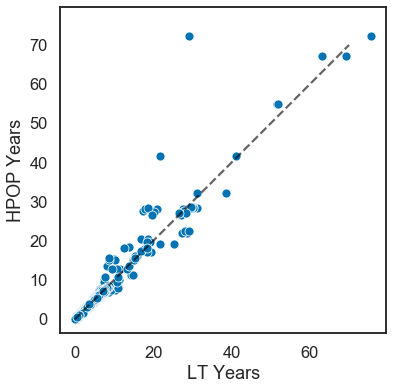

In [23]:
# Plot LT vs HPOP Years Prediction
plt.figure(figsize=(6, 6))
sns.scatterplot('LT Years','HPOP Years',data=dfPlotting)
plt.plot([0 ,70],[0,70],'k--',label='slope = 1',alpha=0.6)
plt.axis('square');

As expected, HPOP and the LifeTime Tool are highly correlated and give similar predictions for orbital lifetimes. A diagonal line is plotted to show what a perfect correlation would be. But there are a few points that seem to give different answers to orbit lifetime. 

When working with the Lifetime Tool, there have been reports of a growing eccentricity and thus a shortened lifetime when the 2nd Order Oblateness check box was selected. Let's categorize the data into groups to see if this behaviour is observed. The next few cells show the difference between the two groups in terms of orbital lifetime predictions.

In [24]:
# Compare the effects of turning on the 2nd Order Oblateness term
# Look at LT Years, HPOP Years, Years % Error
dfPlotting.groupby('2nd Order Oblateness').describe()[['Years Signed Error','Years Abs Error','Years % Error']]

Years Signed Error                                 \
                                  count      mean       std        min   
2nd Order Oblateness                                                     
Off                               533.0  0.024987  0.649456  -7.035263   
On                                533.0 -0.266783  2.425270 -43.058265   

                                                             Years Abs Error  \
                           25%       50%       75%       max           count   
2nd Order Oblateness                                                           
Off                  -0.073681  0.000729  0.072694  6.445370           533.0   
On                   -0.181940 -0.036368  0.032790  6.508852           533.0   

                                                                        \
                          mean       std       min       25%       50%   
2nd Order Oblateness                                                     
Off                   0.213328  0.613861  0.000008  0.023472  0.073681   
On                    0.560123  2.374640  0.000021  0.035169  0.131202   

                                          Years % Error                      \
                           75%        max         count      mean       std   
2nd Order Oblateness                                                          
Off                   0.183857   7.035263         533.0  6.595185  6.584992   
On                    0.271159  43.058265         533.0  8.998978  8.391068   

                                                                          
                           min       25%       50%        75%        max  
2nd Order Oblateness                                                      
Off                   0.007082  1.777609  4.182075   9.918383  31.009811  
On                    0.017326  3.152654  6.510913  11.726365  59.608896

Off Slope: 0.9951089479078331
On Slope: 1.0777256928296168


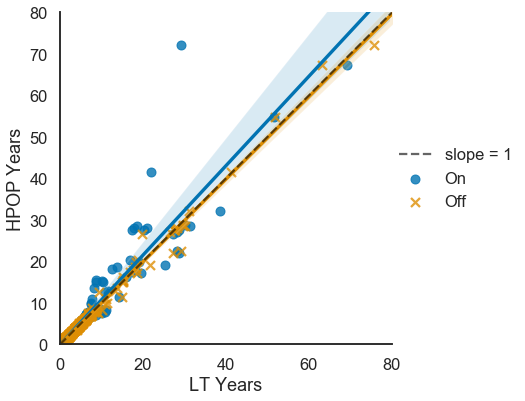

In [25]:
# Plot LT vs HPOP Years Prediction
lim = 80
g = sns.lmplot('LT Years','HPOP Years',hue='2nd Order Oblateness',legend=False,data=dfPlotting,markers=['o','x']);
g.fig.set_figheight(6)
g.fig.set_figwidth(6)
plt.plot([0 ,lim],[0,lim],'k--',label='slope = 1',alpha=0.6)
plt.axis('square');
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.5),borderaxespad=0, frameon=False);
plt.xlim(0,lim)
plt.ylim(0,lim)
dfResOff = dfPlotting[dfPlotting['2nd Order Oblateness']=='Off']
dfResOn = dfPlotting[dfPlotting['2nd Order Oblateness']=='On']
print('Off Slope: '+str(sp.stats.linregress(dfResOff['LT Years'],dfResOff['HPOP Years']).slope))
print('On Slope: '+str(sp.stats.linregress(dfResOn['LT Years'],dfResOn['HPOP Years']).slope))

Off Slope: 0.9951089479078331
On Slope: 1.0777256928296168


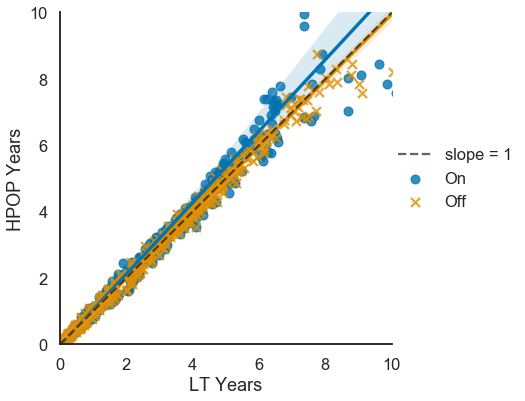

In [26]:
# Plot LT vs HPOP Years Prediction Zoomed In
lim = 10
g = sns.lmplot('LT Years','HPOP Years',hue='2nd Order Oblateness',legend=False,data=dfPlotting,markers=['o','x']);
g.fig.set_figheight(6)
g.fig.set_figwidth(6)
plt.plot([0 ,lim],[0,lim],'k--',label='slope = 1',alpha=0.6)
plt.axis('square');
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.5),borderaxespad=0, frameon=False);
plt.xlim(0,lim)
plt.ylim(0,lim)
dfResOff = dfPlotting[dfPlotting['2nd Order Oblateness']=='Off']
dfResOn = dfPlotting[dfPlotting['2nd Order Oblateness']=='On']
print('Off Slope: '+str(sp.stats.linregress(dfResOff['LT Years'],dfResOff['HPOP Years']).slope))
print('On Slope: '+str(sp.stats.linregress(dfResOn['LT Years'],dfResOn['HPOP Years']).slope))

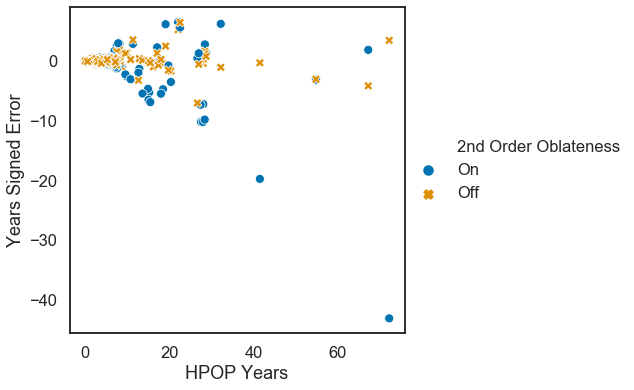

In [27]:
# Signed Error
plt.figure(figsize=(6, 6))
sns.scatterplot('HPOP Years','Years Signed Error',hue='2nd Order Oblateness',data=dfPlotting,style='2nd Order Oblateness');
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.5),borderaxespad=0, frameon=False);

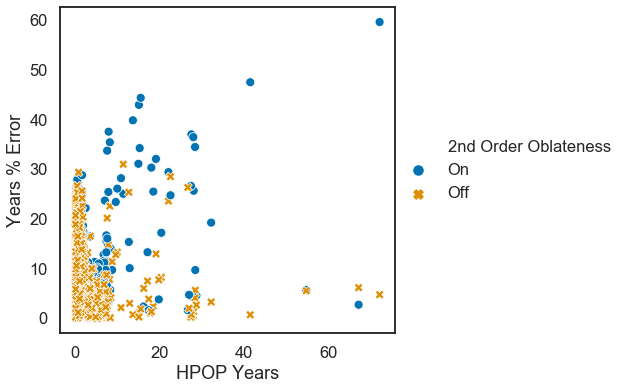

In [28]:
# Percent Error
plt.figure(figsize=(6, 6))
sns.scatterplot('HPOP Years','Years % Error',hue='2nd Order Oblateness',data=dfPlotting,style='2nd Order Oblateness');
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.5),borderaxespad=0, frameon=False);

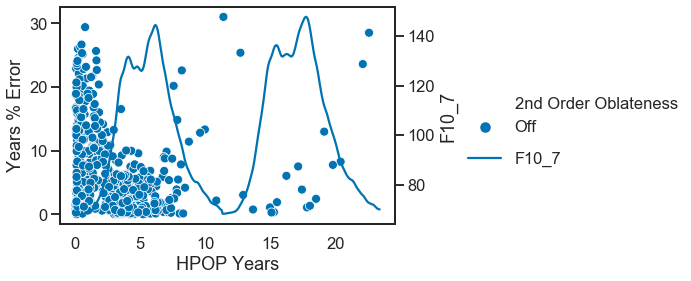

In [29]:
# Percent Error Varys with solar cycle
dfSolFlux = solFluxVals()
dfPlotting2 = dfPlotting[(dfPlotting['HPOP Years']<25) & (dfPlotting['2nd Order Oblateness']=='Off')]
ax = sns.scatterplot('HPOP Years','Years % Error',hue='2nd Order Oblateness',data=dfPlotting2);
plt.legend(loc='center left', bbox_to_anchor= (1.2, 0.5),borderaxespad=0, frameon=False);
ax2 = ax.twinx()
sns.lineplot('EpYears','F10_7',data=dfSolFlux,ax=ax2,label='F10_7');
plt.legend(loc='center left', bbox_to_anchor= (1.2, 0.3),borderaxespad=0, frameon=False);

A couple of things stand out here:

The slope with the 2nd order oblateness term turned off is 0.995 which matches HPOP pretty well! 
The slope with it turned on is 1.077 which is largely caused by shorter lifetimes predictions compared to HPOP. The difference in the predictions becomes more noticable for orbits with longer lifetimes.

The mean % error with the 2nd order oblateness term turned off is 6.6% and a median of 4.2%.
The mean % error with the 2nd order oblateness term turned on is 9.0% and a median of 6.5%.

The largest % error with the 2nd order term off was 31%.
The largest % error with the 2nd order term on was 59 %.

The % error appears to approximately be 180 degrees out of phase with the F10_7 values. Thus the % error shrinks during the solar maximums, which would make sense as most satellites would come in during this time.

As of STK 11.7, I would recommend running your lifetime analysis with this term turned off and in most cases you can reasonably trust your results to be within 5-10% or better of HPOP values. A little more so if the orbit is predicted to come down during a solar maximum and a little so if the orbit is expected to come down during a solar minimum.

### Looking at the accuracy vs runtime trade off

The other two configuration options, Gaussian Quadratures and Orbits Per Calculations, have an almost linear relationship with runtime. Setting Orbits Per Calculation = 10 will reevaluate the change in orbital elements every 10 orbits, decreasing this value will increase the frequency of which these orbital elements are reevaluated. Decreasing the value will tend to also tend to slightly decrease the expected orbital lifetime because drag is evaluated more frequently instead of holding drag constant for 10 revs. Setting Gaussian Quadratures = 1 controls how often density is sampled per orbit. Adjusting these values adjusts the number of calculations that the LifeTime Tool has to make, which can have a substantial impact on runtime. If you are only running Lifetime once the runtime usually doesn't really matter, but if you are running it multiple times this can really add up. Let's see if their impact on the answer justifies their increased runtime.

In [30]:
colsToDrop = ['x','y','z','Vx','Vy','Vz','TA','p','LT Orbits','SolarFluxFile','Density Model','2nd Order Oblateness']
corrMat = dfRes.drop(colsToDrop,axis=1).corr()['LT Runtime'].sort_values(ascending=False)
pd.DataFrame(corrMat[abs(corrMat)>0.1][1:]*100)

,LT Runtime
LT Years,49.658186
HPOP Years,48.583674
HPOP Runtime,24.598584
Rp,24.435660
a,23.956801
Gaussian Quad,22.042461
Years Abs Error,21.166424
Ra,16.654054
e,-11.529204
Cr*Sun Area/Mass,-13.422694


In [31]:
#Compare the effects of Gaussian Quadratures
dfRes[dfRes['2nd Order Oblateness']=='Off'].groupby('Gaussian Quad').describe()[['Runtime Ratio','Years % Error']]

Runtime Ratio                                                 \
                      count        mean          std        min        25%   
Gaussian Quad                                                                
1.0                  1599.0  645.930571  3766.404313  16.934340  96.051492   
2.0                  1599.0  373.021141  2224.364129  16.065801  64.527972   
8.0                  1599.0  106.168156   492.236543   4.378043  20.335145   

                                                     Years % Error            \
                      50%         75%            max         count      mean   
Gaussian Quad                                                                  
1.0            347.280191  694.227586  118943.010888        1599.0  6.674564   
2.0            206.615975  396.861080   73867.624999        1599.0  6.659300   
8.0             67.605082  114.617426   13202.696600        1599.0  6.651757   

                                                                            
                    std       min       25%       50%       75%        max  
Gaussian Quad                                                               
1.0            6.664146  0.001064  1.740819  4.306353  9.873421  31.167650  
2.0            6.652282  0.003826  1.728186  4.352627  9.910115  31.086704  
8.0            6.641208  0.001794  1.725478  4.332788  9.845936  31.085168

In [32]:
#Compare the effects of Orb Per Calc
dfRes[dfRes['2nd Order Oblateness']=='Off'].groupby('Orb Per Calc').describe()[['Runtime Ratio','Years % Error']]

Runtime Ratio                                                  \
                     count        mean          std        min         25%   
Orb Per Calc                                                                 
1.0                 1599.0   70.218578   385.939087   4.378043   20.283034   
5.0                 1599.0  376.204487  1973.546367  17.875141   90.798587   
10.0                1599.0  678.696804  3910.573877  16.065801  154.592191   

                                                    Years % Error            \
                     50%         75%            max         count      mean   
Orb Per Calc                                                                  
1.0            42.732592   69.074650   11752.833744        1599.0  6.597354   
5.0           206.615975  395.930192   56759.092036        1599.0  6.650599   
10.0          344.845807  696.290053  118943.010888        1599.0  6.737667   

                                                                           
                   std       min       25%       50%       75%        max  
Orb Per Calc                                                               
1.0           6.577122  0.001064  1.779734  4.182075  9.882236  31.093802  
5.0           6.634489  0.001794  1.693319  4.398939  9.838888  31.130082  
10.0          6.744226  0.003826  1.732099  4.418668  9.930024  31.167650

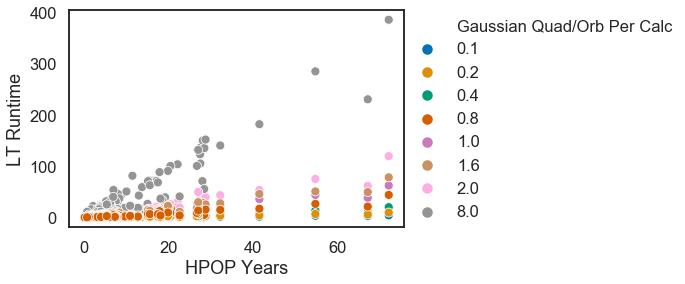

In [33]:
# Look at Runtime
plt.figure();
dfRes['Gaussian Quad/Orb Per Calc'] = dfRes['Gaussian Quad']/dfRes['Orb Per Calc']
g = sns.scatterplot('HPOP Years','LT Runtime',hue = 'Gaussian Quad/Orb Per Calc',palette=sns.color_palette('colorblind')[0:8],legend='full',data=dfRes[dfRes['2nd Order Oblateness']=='Off']);
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.5),borderaxespad=0, frameon=False);

Increasing the Gaussian Quadratures from 1 to 2 saw a 70% increase in runtime and an improvement in lifetime accuracy of 0.02%. Changing from 2 to 8 saw a 350% increase in runtime with only 0.01% improvement in accuracy. Choosing a Gaussian Quadrature of 2 seems like a good value for most orbits to balance the accuracy versus runtime. And increasing Gaussian Quadrature beyond this seem to have little affect on accuracy. Perhaps with the exception of highly eccentric orbits, in which case 4 or 8 may want to be used.

Changing the Orbits per Calc from 10 to 1 shows a 0.18% accuracy improvement, but a computation time increase of 900%. In general increasing the Orbits per Calc will decrease the expected Lifetime slightly because the drag is being sampled more frequenctly. A default of 10 is a reasonable value, but decreasing this value will yield slightly more accurate results at the cost of runtime.

Keeping a Gaussian Quadratures/Orb Per Calc ratio less than 2 will keep most LEO lifetime predictions less than 1 minute. The Lifetime Tool defaults give a ratio of 0.1, which is good for computation speed. Changing the Gaussian Quadratures to 2 gives a slightly more accurate answer for eccentric orbits while maintaining a good computation speed. Additionally lowering the Orbits per Calc down to 1 for slightly more accurate results gives a ratio of 2, which would be the recommended values if runtime is not a big concern.
